In [1]:
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
def N_2(x):
    if type(x) == np.ndarray:
        R = np.zeros_like(x)
        for i in range(len(x)):
            R[i] = N_2(x[i])
        return R
    else:
        if x <= 0:
            return 0
        if x >= 2:
            return 0
        if 0 <= x <= 1:
            return x
        if 1 <= x <=2:
            return 2 - x

In [3]:
def N_1(x):
    if type(x) == np.ndarray:
        R = np.zeros_like(x)
        for i in range(len(x)):
            R[i] = N_1(x[i])
        return R
    else:
        if 0 <=x <= 1:
            return 1
        else:
            return 0

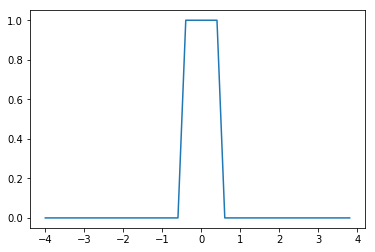

In [4]:
X = np.arange(-20, 20)
plt.plot(X / 5., N_1(X / 5. + 1  / 2))

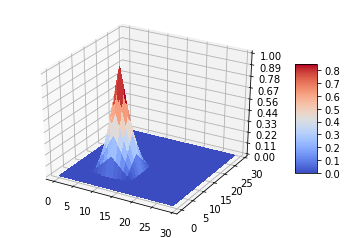

In [5]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0, 30, 1)
Y = np.arange(0, 30, 1)
X, Y = np.meshgrid(X, Y)
Z = N_2((X - 10.) / 5. + 1) * N_2((Y - 10.) / 5. + 1)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [394]:
# First let us create fake data
import scipy.sparse as sp
from scipy.stats import multivariate_normal

#Create grid and multivariate normal
x = np.linspace(-10,10,20)
y = np.linspace(-10,10,20)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
# rv = multivariate_normal([mu_x, mu_y], [[variance_x, 0], [0, variance_y]])

K = sp.random(5, 5, 0.5).toarray()
M = np.zeros((100, 100))
A = np.zeros_like(M)
for i in range(K.shape[0]):
    for j in range(K.shape[1]):
        M[i*20: (i+1)*20, j*20: (j+1)*20] = multivariate_normal([0, 0], [[20, 0], [0, 20]]).pdf(pos) * K[i, j]


noise = np.abs(np.random.multivariate_normal(
        np.zeros(100),
        np.eye(100),
        100
    )) * 1e-3

D = (M + noise) * 150

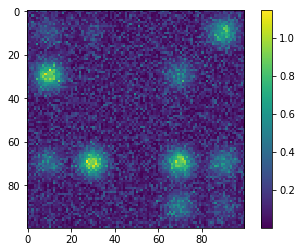

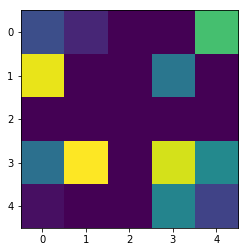

In [440]:
D = D + 1
plt.figure()
plt.imshow(D)
plt.colorbar()
plt.figure()
plt.imshow(K)

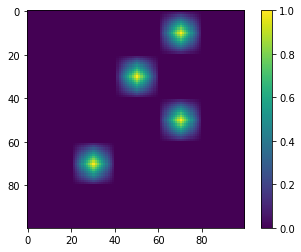

In [441]:
mu = np.array([[70., 30.], [30., 50.], [50., 70.], [10., 70.]])
def pred(mu, l=10.):
    R = np.zeros((100, 100))
    pred = 0
    for i in range(100):
        for j in range(100):
            pred = 0
            for k in range(len(mu)):
                pred += N_2((i - mu[k][0])/l + 1) * N_2((j - mu[k][1])/l + 1)
            R[i, j] = pred
    return R

R = pred(best_mu)
plt.imshow(R)
plt.colorbar()

In [442]:
def e(X, mu, l=10.):
    error = 0
#     for i in range(len(X)):
#         for j in range(len(X[0])):
#             pred = 0
#             for k in range(len(mu)):
#                 pred += N_2((i - mu[k][0]) / l + 1) * N_2((j - mu[k][1])/l + 1)
#             local_error = (X[i, j] - pred)**2
#             error += local_error
    error = np.sum((X - pred(mu))**2)
    return error
print(e(D, mu))

519.9843080162258


In [443]:
def grad_mu(X, mu, m, p, l=10.):
    """
    This is computing the gradient with respect to mu_mp
    """
    grad_mat = np.zeros_like(mu)
    grad = 0
    for i in range(len(X)):
        for j in range(len(X[0])):
            pos = [i, j]
            pred_ij = 0
            for k in range(len(mu)):
                pred_ij += N_2((i- mu[k][0]) / l + 1) * N_2((j - mu[k][1])/l + 1)
            error_ij = X[i, j] - pred_ij
            grad_ij = error_ij
            for s in range(len(pos)):
                if s != p:
                    grad_ij *= N_2((pos[s] - mu[m][s]) / l + 1)
            grad_ij *= 1 / l
            grad_ij *= N_1((pos[p] - mu[m][p])/l + 1) - N_1((pos[p] - mu[m][p])/l)
            grad += grad_ij
    return 2 * grad

def update_mu(X, mu, step=1., l=10.):
    new_mu = np.copy(mu)
    for k in range(len(mu)):
        for m in range(len(mu[0])):
            new_mu[k, m] -= step * grad_mu(X, new_mu, k, m, l=l)
    return new_mu

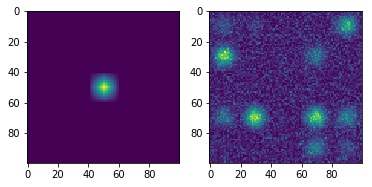

1136.6027201057052
763.3940200301906
608.4246940378795
582.0824821701708
530.8931679733003
531.3282971790695
530.8439263550362
531.6043899395609
531.3872734027988
528.3223560190878
525.1099369302614
523.182968970926
511.5506731999599
457.8512259840245
459.7009100919448
461.1381158872821
455.68948655655043
456.76627153062896
456.38899825552437
454.509371010328


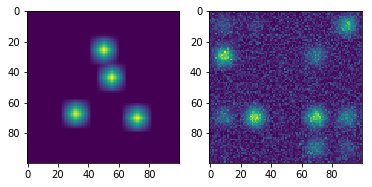

In [449]:
mu = np.ones((4, 2))*50
R = pred(mu, l=10.)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(R)
axes[1].imshow(D)
plt.show()
for n in range(20):
    R = pred(mu, l=10.)
    mu = update_mu(D, mu, l=10., step=1.)
    print(e(D, mu))
R = pred(mu, l=10.)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(R)
axes[1].imshow(D)
plt.show()

In [451]:
xj = []
yj = []
for i in range(100):
    j = i - 50
    xj.append(j)
    yj.append(1 / (1+j**2))
    

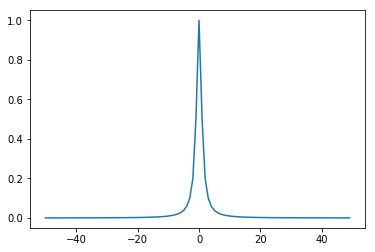

In [452]:
plt.plot(xj, yj)